## Jugando con el gradiente descendente

Los algoritmos de optimización por gradiente descendente son cada vez más populares, y a menudo son utilizados como cajas negras con explicaciones prácticas de sus fortalezas y sus debilidades. El objetivo de este artículo es proporcionarle al lector una pequeña intuición y los conocimientos mínimos en matemáticas para entender mejor el comportamiento de estos algoritmos y tener criterios sólidos para ponerlos en uso. En el curso de esta descripción general, estudiaremos las diferentes variantes de los gradientes descendentes y sus principales desafíos.

El aprendizaje mecánico y la estadística comparten importantes características, pero usan una terminología diferente. En estadística, la regresión lineal se utiliza para modelar una relación $\mathcal{R}\subseteq\mathcal{X}\times\mathcal{Y}$ a partir  de una muestra de datos $S\subset \mathcal{R}\subseteq\mathcal{X}\times\mathcal{Y}\subseteq\mathbb{R}^{m+1}\times\mathbb{R}$. Usualmente los datos que provienen de $\mathcal{X}$ se denominan <em>variables independientes</em> y los que provienen de $\mathcal{Y}$ se denominan <em>variables dependientes</em>. En el contexto del aprendizaje mecánico, este es llamado un <em>problema de aprendizaje supervisado</em>. El conjunto $S=\{(x_i, y_i)\}_{i=0}^{k}$ se denomina <em>conjunto de entrenamiento</em> y el par de valores $(x_i, y_i)$ es un <em>ejemplo de entrenamiento</em> del conjunto $S$ de $k$ ejemplos de entrenamiento.

Cada $x_i$ es considerado como un vector columna de la forma $x_i=(1, x_{i,1},\dots,x_{i,m})^{\top}$ de dimensión $m+1$, a menudo es referido como el predictor en la literatura estadística. El proposito de la regresión lineal es identificar el mejor <em>predictor</em> de la clase de predictores de la forma $y =\theta^{\top} x$, donde $\theta \in \mathbb{R}^{m+1}$ y es de la forma $\theta =(\theta_0, \dots, \theta_m)^\top$, el parámetro $\theta_0$ se denomina <em>bias</em>. Para hacer esto, se considera la matriz $X\in M_{k\times m+1}(\mathbb{R})$ donde la $i$ - ésima fila está dada por el $i$ - ésimo vector fila $x_i^{\top}$. De esta manera se obtiene una expresión general para predecir los valores de $\mathcal{Y}$ que viene dada por el modelo:  

\begin{equation}\nonumber
Y=X\theta.
\end{equation} 

En Python podemos definir la clase de predictores lineales $y =\theta^{\top} x$ de la siguiente forma:

In [1]:
import numpy as np

class LinearPredictor:
    
    def __init__(self, m):
        """
        Input:
            theta: initial predictor.
            
        Output:
            None.
        """
        
        # The coefficient column vector is initialized to zero.
        self.theta = np.zeros(m + 1).reshape(-1, 1)
        
    def predict(self, x):
        """
        Input:
            x: list of float values of the form [1, x_1, ... ,x_m].
            
        Output:
            Returns the dot product (float) between «theta» and «x». 
        """
        
        # We define theta as self.theta.
        theta = self.theta        
        # Convert «x list» to a column vector.
        x = np.array(x).reshape(-1, 1)
        
        # Returns the product of the matrices theta and x.
        return float(theta.T.dot(x))

Observe que en el código anterior, el vector de coeficientes $\theta$ se puede inicializar a elección del lector, lo importante aquí, es ir actualizandolo hasta encontrar el mejor de ellos. Este problema de encontrar el mejor predictor lineal se resuelve eligiendo algún vector de coeficientes $\theta$ que minimizan la suma residual de cuadrados:

\begin{equation}\nonumber
E_S(\theta)=(Y-X\theta)^\top (Y-X\theta).
\end{equation}

En la ecuación anterior, $Y$ es el vector columna  donde la $i$ - ésima entrada está dada por cada etiqueta $y_i$  definida en el conjunto de entrenamiento $S$, es decir, $Y = (y_1,\dots, y_k)^\top$. Esto permite definir el problema como un problema de minimización del riesgo empirico (ERM) dado por:

<a id='1'></a>
\begin{equation}\tag{1}
ERM_{\theta}(S)\equiv \operatorname*{argmin\,\,}_{ \theta \in \mathbb{R}^{m+1}} E_{S}(\theta),
\end{equation}

que es equivalente a  escoger un vector $\hat{\theta}\in ERM_{\theta}(S)$[<sup>2](#2) para la solución del problema de optimización en la [Ecuación 1](#1). Para estudios de simulación, se puede construir un modelo sintético a partir de la generación de datos con: 

<a id='2'></a>
\begin{equation}\tag{2}
Y=X\xi + \epsilon,
\end{equation} 

donde $\epsilon\sim \mathcal{N}(0, \sigma^2I_{k})$. Esto se puede implementar fácilmente en Python de la siguiente forma:

In [2]:
class SyntheticData:

    def __init__(self, m):
        """
        Input:
            m: dimension of the space of independent variables.
            
        Output:
            None.
        """
        
        # Dimensión of the data.
        self.m = m
        
        # The vector of coefficients is chosen at random.
        self.xi = np.random.rand(m + 1).reshape(-1, 1)        
          
    def generate(self, k, sigma):
        """
        Input:
            k: the amount of data to generate.
            sigma: standard deviation.
            
        Output:
            Returns a tuple with X, y and xi.
        """
        
        # A column vector of ones is constructed.
        ones = np.ones(k).reshape(-1, 1)
        
        # Random data is generated and added to the ones vector.
        X = np.hstack((ones, np.random.rand(k, self.m)))        
        
        # Random noise is generated.
        epsilon = sigma * np.random.standard_normal(k)
        
        # Values for y are constructed.
        y = X.dot(self.xi) + epsilon.reshape(-1, 1)

        return X, y, self.xi

Para entender el comportamiendo del gradiente de descente es conveniente probar con diferentes colecciones de datos o lotes, para eso sea:

\begin{equation}\nonumber
    S_{l}=\{X_{l}, Y_{l}\}_{l\in[r]_{\mathbb{N}_0}}, 
\end{equation} 

una colección de $r$ simulaciones[<sup>2](#2). En Python podemos hacer una implementación sencilla para generar estos lotes de datos, esto sería algo así:

In [3]:
def generate_batches(m, k, r, sigma):
    """
    Input:
        m: dimension of the space of independent variables.
        k: the amount of data to generate by batch.
        r: number of batchs.
        sigma: standard deviation.
    
    Output: 
        List with generated batches.        
    """
    
    # We generate the synthetic data for each batch.
    synthetic_data = SyntheticData(m)
    batches = [synthetic_data.generate(k, sigma) for _ in range(r)]
    
    return batches

El objetivo de la [Ecuación 1](#1) es encontrar un vector $\hat{\theta}\in ERM_{\theta}(S)$ , para nuestro ejercicio esto se traduce en estimar el vector $\hat{\theta}$ tan cerca como sea posible al parámetro conocido $\xi$ del modelo simulado en la [Ecuación 2](#2).

El indicador que se utilizará para comparar la estimación de los coeficientes $\hat{\theta}$ con los coeficientes verdaderos $\xi$ será el error cuadrático medio (RMSE). Esta medición se utilizará para evaluar el rendimiento en cada una de la simulaciones $S_l$. Tenga en cuenta que el RMSE se calculan para un elemento específico en el vector $\theta$. La notación $\operatorname{RMSE}_d$ enfatizará a qué parámetro se refiere. Para los parámetros $d\in [m]_{\mathbb{N_0}}$, considere:

\begin{equation}
\operatorname{RMSE}_d = \left(\frac{1}{r}\sum_{j=0}^{r}\big(\theta^{(d)}_j-\xi^{(d)}\big)^{2}\right)^{\frac{1}{2}}.
\end{equation}

Así se obtiene $\operatorname{RMSE} = (\operatorname{RMSE}_0,\dots, \operatorname{RMSE}_{m})$. En Python se tendría algo así:

In [4]:
def RMSE(matrix_theta: list, xi: list, r: int) -> np.array:
    """
    Input:
        matrix_theta: this a matrix of values theta for each S.
        xi: synthetic parameters.
        r: number of simulations. 
        
    Output:
        RMSE
    """
    
    matrix_theta = np.array(matrix_theta)
    xi = np.array(xi).reshape(-1, 1)
    arg = 1/r * (matrix_theta - xi)**2
    
    return np.sqrt(arg.sum(axis=1))

En el código anterior se espera como parámetro de entrada una matriz $\Theta$ donde cada $l$ - ésima columna es el $l$ - vector de coeficientes aprendido para la $l$ - ésima simulación de datos $X_{l}$, esto se explicará con más detalle a continuación.

Si se asume que $h_{\theta}$ es un predictor para el conjunto de datos $S_{l}=\{X_{l}, y_{l}\}$, entonces el problema de regresión lineal en la [Ecuación 1](#1) se puede reescribir con la siguiente función de costo:

\begin{equation}\tag{3}
E_{S}(\theta)=\frac{1}{2k}\sum_{i=1}^{k}\big(h_{\theta}(x_i)-y_i\big)^2.
\end{equation}

Esta función para la costo es facil de implementar en Python como podemos ver a continuación:

In [5]:
def loss(predictor, sample: tuple) -> float:
    """
    Input:
        predictor: linear predictor. 
        sample: dataset.
    
    Output:
        loss.    
    """
    
    arg = list()
    k = len(sample[0])
    
    for i in range(k):
        x_i = sample[0][i]
        y_i = sample[1][i]
        k = len(sample[0])
        arg.append((predictor.predict(x_i) - y_i)**2)
        
    return 1/(2*k) * sum(arg) 

Una forma de resolver este problema es utilizar los métodos del gradiente descente. Estos son algoritmos que hacen uso de las derivadas parciales de funciones diferenciales convexas y, como cualquier algoritmo, su eficiencia puede ser monitoreada. Principalmente, la eficiencia de un algoritmo depende de que tan precisa es la estimación que produce. En segundo lugar, se analiza su capacidad para producir tal estimación dentro de un marco de tiempo factible.

Los métodos del gradiente descendente produce secuencias finitas de números $\theta$. Para ser eficiente esta secuencia debería converger al valor óptimo. En este ejercicio, para algún $\delta > 0$, la eficacia de un algoritmo se evalúa midiendo la duración para producir una estimación $\hat{\theta}$ con precisión $\delta$ tal que:

\begin{equation}
||\hat{\theta}-\xi||<\delta
\end{equation}

En lugar de una respuesta continua $y$, la respuesta podría ser binaria, es decir, $y \in \{0, 1\}$. En estadística, este es un modelo de regresión logística. Dados ciertos predictores, también es un problema de aprendizaje supervisado. Las premisas para resolver un problema de regresión logística son similares a las de un problema continuo. En el caso binario el problema se resuelve para la siguiente función de costo:

<a id='4'></a>
\begin{equation}\tag{4}
E_{S}(\theta) = \frac{1}{m}\bigg(\sum_{i=1}^{m}\Big(y_i\log h_{\theta}\big(x_i\big) + \big(1-y_i\big)\log \big(1 - h_{\theta}\big(x_i\big)\big)\Big)\bigg)
\end{equation}

donde

\begin{equation}
h_{\theta}(x) = \frac{1}{1+e^{-\theta^\top x}}
\end{equation}

Esta es una función convexa y suave. Por lo tanto, el proceso de solución es similar al de la [Ecuación 1](#1). Pero aquí, la variable dependiente $y$ es categórica. Si $y$ tiene más de dos resultados posibles, el modelo se llama regresión logística multinomial.

## Gradiente descendente (GD)

Para calcular la solución del objetivo de optimización hay que minimizar la función de costo $E_{S}(\theta)$. Su gradiente se representa por $\nabla E_{S}(\theta)$ y revela en cual direción la función decrese más rápido (<a src ='https://alejandrosanchezyali.blogspot.com/2020/10/algoritmo-del-gradiente-descendente.html'>Ver Gradiente Descendente</a>). Utilizando $\nabla E_{S}(\theta)$ es posible dar pasos repetidamente hacia un mínimo local. Esto sugiere el siguiente algoritmo: 

#### *Algoritmo 1. Gradiente Descendente Clásico*
<blockquote>    
Input: $\theta$, $X$, $Y$, $t$, $ \alpha$, $\nabla E_{S}$
<br>1. &nbsp; &nbsp;&nbsp;for $k=0$ to $p$ do:
<br>2. &nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S}(\theta, X, Y)$
<br>3. &nbsp; &nbsp;&nbsp;end    
<br>return: $\theta$

</blockquote>

En el seudocódigo anterior se tiene que $t$ es el número máximo de iteraciones y $\alpha$  es la tasa de aprendizaje, hiperparámetros que son ajustados manualmente. Hay métodos que  permite aproximar la tasa de aprendizaje  para acelerar la convergencia, pero aquí en nuestro caso,  el descenso del gradiente se mantendrá en su forma pura. Cuando $\alpha$ se elige lejos de su valor óptimo $\alpha^*$, el algoritmo divergerá si $\alpha > \alpha^*$ y convergerá muy lentamente si $\alpha < \alpha^*$. 

Recordemos la función objetivo $E(\theta)$ en [Ecuación 1](#1). Sea

\begin{equation}
h_{\theta}(x)= \theta^\top x
\end{equation}

Si el número de ejemplos de entrenamiento es $k$, el número de parámetros es $m+1$, entonces entonces considerando $j=0, \cdots, m$ y $e_0,\dots,e_m$ la base estandar, entonces el gradiente de $E_{S}(\theta)$ se puede expresar como:

\begin{equation}
\nabla E_{S}(\theta) = \sum_{i=0}^{m}\frac{\partial E}{\partial \theta_{i}}e_{i}
\end{equation}

donde

\begin{equation}
\frac{\partial E_{S}}{\partial \theta_{j}}=\frac{1}{k}\sum_{i=1}^{k}\big(\theta^\top x_i-y_i\big)x_{i,j}.
\end{equation}

La convergencia del algoritmo del gradiente descendente depende de la elección precisa de la tasa de aprendizaje $\alpha$, así como del número suficiente de iteraciones $t$. Nuestro caso es un problema de optimización convexo y tomando hiperparámetros apropiados, es decir $0<\alpha <1$, el algoritmo debería converger. 

Para la [Ecuación 4](#4), el objetivo es la optimización para la regresión logística, la función de costo es otra, pero nuevamente podemos obtener el gradiente de la siguiente manera:

\begin{equation}
\frac{\partial E_{S}}{\partial \theta_{j}}=\frac{1}{k}\sum_{i=1}^{k}\big(h_{\theta}(x)-y_i\big)x_{i,j},
\end{equation}

donde $h_{\theta}(x) = \frac{1}{1+e^{-\theta^\top x}}$. Como la ecuación $E_{S}(\theta)$ para la regresión logistica vuelve a ser una función convexa, entonces se puede usar los algoritmos basados en el gradiente para minimizar la [Ecuación 4](#4).

A continuación se presenta la implementación del algoritmo del gradiente descendente en python:

In [6]:
def gd(predictor, X, Y, t, alpha, gradient):
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        
    Output:
        The best predictor.
    """
    
    theta = predictor.theta
    iterations = 0
    
    while iterations <= t:
        theta = theta - alpha * gradient(theta, X, Y)
        iterations += 1
        
    predictor.theta = theta
    
    return predictor

Para poder hacer el análisis de comportamiento del GD, se harán algunas modificaciones en el algoritmo anterior, que permite obtener información acerca del comportamiento de la función de costo, de la distancia a los parámetros originales de los datos simulados y el tiempo de ejecución. Antes de enseñarte la modificación, vamos a definir una función para medir la distancia euclidiana entre los diferentes parámetros:

In [7]:
def euclidean_distance(theta, xi):
    """
    Input:
        theta: it's an array with predict parameters.
        xi: it's an array with real parameters
        
    Output:
        This function return the norm of theta - xi.
    """
    
    arg = theta - xi
    return np.linalg.norm(arg)

Además también es necesario definir el gradiente para la función de costo, en este caso sólo se hará para la regresión lineal:

In [8]:
def gradient(theta, X, Y):
    """
    Input: 
        theta: it's an array with predict parameters.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
    Output:
        Return the gradient for the loss function.
    """
    
    if len(X.shape)==1:
        X = X.reshape(1, -1)
    return X.T.dot((X.dot(theta)- Y))

Finalmente, el algoritmo modificado sería el siguiente:

In [9]:
import timeit


def gd(predictor, X, Y, t, alpha, gradient, loss, xi):    
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        loss: it's the loss function.
        xi: it's ana array with real parameters.         
        
    Output:
        This function return the best predictor with errors and the delta 
        between real parameters and predict paremeters. 
    """
    
    theta = predictor.theta
    iterations = 0    
    
    delta_theta = list()
    deltas_thetas = theta.reshape(-1, 1) - xi.reshape(-1, 1)    
    errors = list()
    sample = tuple([X, Y])
    
    while iterations <= t:
        
        gradient_ = gradient(theta, X, Y)
        theta = theta - alpha * gradient_
        predictor.theta = theta        

        delta_theta.append(euclidean_distance(theta, xi))
        arg = theta-xi
        deltas_thetas = np.hstack((deltas_thetas, arg))          
        errors.append(loss(predictor=predictor, sample=sample))
            
        iterations += 1
        
    return predictor, errors, delta_theta, deltas_thetas

### Algunos código adicionales para analizar el comportamiento del GD

Para analizar el comportamiento del GD y sus diferentes variantes la siguiente función nos va a permitir registrar los principales parámetros de comportamiento:

In [10]:
import time

def simulator(m, k, r, sigma, gradient_method, parameters_grad):
    """
    Input:
        m: dimension of the space of independent variables.
        k: the amount of data to generate by batch.
        r: number of batchs.
        sigma: standard deviation.
        gradient_method:there are three options (gd, sgd, sdg_mini_batch)
        parameters_grad: parameter for the gradient method.
        
    Output:
        This function returns the following lists: errors, deltas, deltas_theta, rmse, times.        
    """
    
    batches = generate_batches(m, k, r, sigma)
    parameters['xi'] = batches[0][2]
    
    matrix_theta = list()
    errors = list()
    deltas_theta = list()
    deltas = list()
    times = list()
        
    for batch in batches:
        
        parameters_grad['X'] = batch[0]
        parameters_grad['Y'] = batch[1]
        parameters_grad['predictor'] = LinearPredictor(m)
        
        start = time.time()
        predictor, error, delta_theta, delta = gradient_method(**parameters_grad)
        end = time.time()
        
        delta_time = end - start
        
        errors.append(error)
        deltas.append(delta)
        deltas_theta.append(delta_theta)
        matrix_theta.append(predictor.theta)
        times.append(delta_time)
        
    matrix_theta = np.array(matrix_theta)
    matrix_theta = matrix_theta.squeeze().T
    xi = parameters.get('xi')
    rmse = RMSE(matrix_theta=matrix_theta, xi=xi, r=r)
   
    return errors, deltas, deltas_theta, rmse, times

Además para hacer varias ejecuciones de la función anterior también vamos a hacer uso de la siguiente función:

In [11]:
from statistics import mean

def execute(m, k, r, sigmas, gradient_method, parameters_grad):
    """
    Input:
        m: dimension of the space of independent variables.
        k: the amount of data to generate by batch.
        r: number of batchs.
        sigma: list with several values for the standard deviation.
        gradient_method:there are three options (gd, sgd, sdg_mini_batch)
        parameters_grad: parameter for the gradient method.
    
    Ouput:
        This function returns the following lists: errors, deltas, delta_thetas rmses, times. 
    """
    errors = list()
    deltas = list()
    deltas_theta = list()
    rmses = list()
    times = list()   


    for sigma in sigmas:
        
        parameters = dict(
            m=m, 
            k=k, 
            r=r, 
            sigma=sigma,
            gradient_method=gradient_method, 
            parameters_grad=parameters_grad
        )

        error, delta, delta_theta, rmse, time_ = simulator(**parameters)
        errors.append(error)
        deltas.append(delta)
        deltas_theta.append(delta_theta)
        rmses.append(rmse)
        times.append(round(mean(time_), 3))
        
    return errors, deltas, deltas_theta, rmses, times

Necesitamos además de las siguientes funciones para graficar los resultados:

In [12]:
import matplotlib.pyplot as plt

def plot_errors(errors, sigmas, axis_range=[0, 200, 0, 1]):
    """
    Input:
        errors: array with all errors from each iteration in execute function.
        sigmas: list with the standard deviations for each iteration in execute function.
    
    Output:
        Figure with error plots.
    """
    
    fig, axs = plt.subplots(3, 2, figsize=(10, 12))
      
    j = 0    
    for axis, error in zip(axs.flat, errors):
        
        i = 0
        for e in error:
            
            axis.plot(e, label='batch {}'.format(i))
            axis.axis(axis_range)
            axis.legend()
            i += 1
            
        axis.set_title(r'$\sigma = {}$'.format(sigmas[j]))
        j += 1
        
    plt.suptitle('Loss vs Iterations')
    plt.setp(axs[-1, :], xlabel='N° Iterations')
    plt.setp(axs[:,0], ylabel='Loss')

    
def plot_deltas(deltas_theta, sigmas, axis_range=[0, 200, -2, 2]):
    """
    Input:
        deltas_theta: array with deltas for each iteration in execute function.
        sigmas: list with the standard deviations for each iteration in execute function.
    
    Output:
        Figure with delta plots.
    """
    
    fig, axs = plt.subplots(3, 2, figsize=(10, 12))
    zeros = [0] * 200
    j = 0    
    for axis, delta in zip(axs.flat, deltas_theta):
        
        i = 0
        for d in delta:
            
            axis.plot(zeros, 'k')
            axis.plot(d, label='batch {}'.format(i))
            axis.axis(axis_range)
            axis.legend()
            i += 1
            
        axis.set_title(r'$\sigma = {}$'.format(sigmas[j]))
        j += 1
        
    plt.suptitle(r'Distance between $\theta$ and $\xi$')
    plt.setp(axs[-1, :], xlabel='N° Iterations')
    plt.setp(axs[:,0], ylabel='Distance')
    
    
def plot_deltas_parameters(deltas, axis_range=[0, 200, -2, 2]):
    """
    Input: 
        deltas: array with deltas for each iteration in execute function.
    
    Output:
        Figure with delta plots.
    
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    zeros = [0] * 200
    batches = len(deltas)
    m = len(deltas[0])
    
    switch = True    
    for j in range(m + 1):
        for k, axis in enumerate(axs.flat):
            for i in range(batches):
                if j == k:
                    axis.plot(zeros, 'k')
                    axis.plot(deltas[i][j])
                    axis.set_title(r'$\theta_{}$'.format(j))
                    axis.axis(axis_range)

### Simulaciones del GD en ambientes controlados

A continuación se va a ejecutar variables simulaciones con desviación estándar $\sigma = 0.1, 0.2, 0.4, 0.4, 0.6, 0.8$ con $m=3$ y  seis lotes de 200 datos. Además vamos a considerar todas las simulaciones con un número máximo de 200 iteraciones y una tasa de aprendizaje de 0.001. El lector puede variar estos parámetros para hacer sus propios análisis. La configuración sería:

In [13]:
parameters = dict(t=200, alpha=0.001, gradient=gradient, loss=loss)
sigmas = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
m, k, r = 3, 200, 5

Ejecutamos las simulaciones:

In [14]:
answers = execute(m=m, k=k, r=r, sigmas=sigmas, gradient_method=gd, parameters_grad=parameters)
errors, deltas, deltas_theta, rmses, times = answers

Y visualiazamos cada unos de los resultados. A continuación vemos el comportamiento de la función de costo para uno de los valores de sigma:

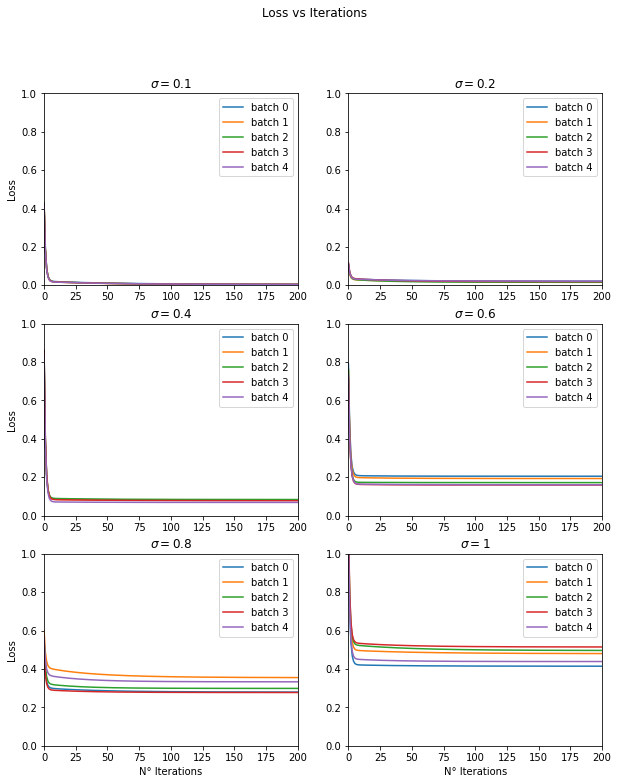

In [15]:
plot_errors(errors, sigmas, axis_range=[0, 200, 0, 1])

El lector puede observar que el comportamiento de la función de costo es peor a medida que los valores de la desviación estándar aumenta. Esto quiere decir que debemos cuidarnos de los datos propensos a un nivel alto de ruido porque las conclusiones que  puede arrojar el modelo pueden carecer de sentido.

Para las distancias entre $\theta$ y $\xi$ obtenidas en cada una de las iteraciones, el lector podrá encontrar que hay una perdida de homogeneidad en la convergencia de las distancias a medida que los valores de $\sigma$ se incrementa. Esto nos sugiere de nuevo que debemos preferir los datos con bajos niveles de desviación estándar. 

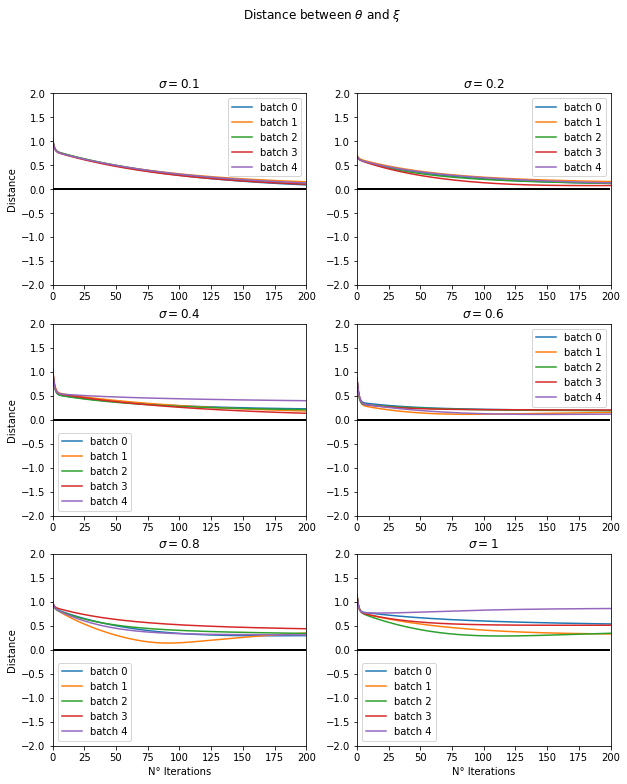

In [16]:
plot_deltas(deltas_theta, sigmas)

En cuanto a cada uno de los parámetros de $\theta$ hay que tener presente que las simulaciones se ejecutaron con $m=3$, es decir que $\theta$ tiene con cuatro parámetros.

En los resultados obtenidos, las iteraciones con $\sigma$ igual a $0.1$ y $0.2$ presentan el comportamiento más homogéneo como se puede observar a continuación.

#### Resultados de los parámetros para la iteración 0:

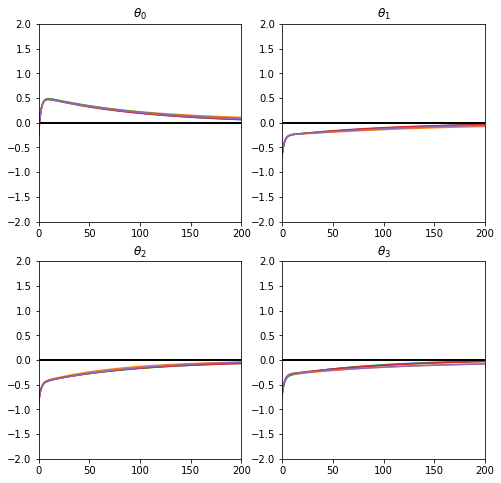

In [17]:
plot_deltas_parameters(deltas[0])

#### Resultados de los parámetros para la iteración 1:

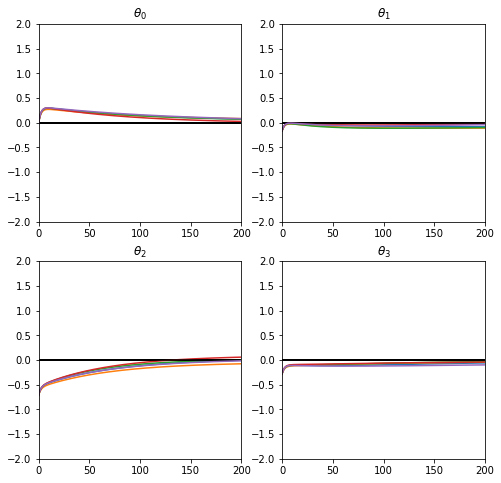

In [18]:
plot_deltas_parameters(deltas[1])

Con respecto a las demás iteraciones con valores de $\sigma$ iguales a $0.4, 0.6, 0.8, 1$ hay una perdida notable en la homogeneidad de los resultados como se puede observar a continuación.

#### Resultados de los parámetros para la iteración 2:

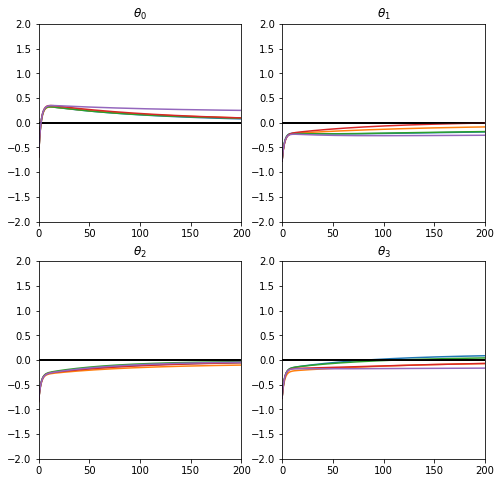

In [19]:
plot_deltas_parameters(deltas[2])

#### Resultados de los parámetros para la iteración 3:

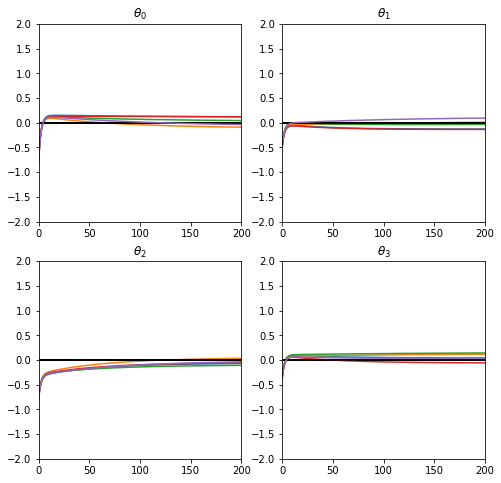

In [20]:
plot_deltas_parameters(deltas[3])

#### Resultados de los parámetros para la iteración 4

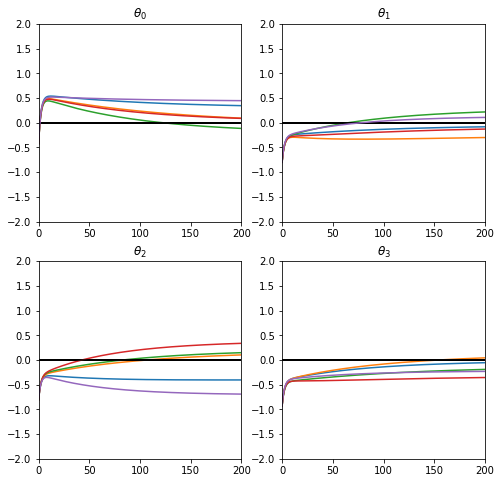

In [21]:
plot_deltas_parameters(deltas[5])

Finalmente, para visualizar el RMSE y los tiempos de ejecución, necesitamos de la siguiente función:

In [22]:
import pandas as pd

def results(rmses, times):
    """
    Input:
        rmses: array with rmses for each iteration of the execution fuction.
        times: array with times for each iteration of the execution fuction.
    Output:
        DataFrame with all results of the simulations. 
    """
    columns = columns = [r'RMSE $\theta_0$', r'RMSE $\theta_1$', r'RMSE $\theta_2$', r'RMSE $\theta_3$']
    index=[r'$\sigma=0.1$', r'$\sigma=0.2$', r'$\sigma=0.4$', r'$\sigma=0.6$', r'$\sigma=0.8$', r'$\sigma=1.0$']
    result = pd.DataFrame(rmses, columns=columns, index=index)
    result['times (seg)'] = times
    return result   

Antes de presentar los resultado para los RMSE y los tiempos de ejecución, es importante tener presente que los tiempos de ejecución varía de acuerdo a la computadora que se esté usando. La computadora que se usó en estos calculos fue una Asus Zenpro UX410U con procesador Intel CORE i5 7th Gen y 16 GB de RAM, los resultados obtenidos en esta maquina fueron:

In [23]:
results(rmses, times)

,RMSE $\theta_0$,RMSE $\theta_1$,RMSE $\theta_2$,RMSE $\theta_3$,times (seg)
$\sigma=0.1$,0.081199,0.049313,0.057691,0.054090,0.320
$\sigma=0.2$,0.071035,0.077761,0.043565,0.060215,0.306
$\sigma=0.4$,0.138711,0.165536,0.062829,0.096560,0.283
$\sigma=0.6$,0.090134,0.094614,0.067607,0.089843,0.292
$\sigma=0.8$,0.210836,0.130793,0.169189,0.184196,0.272
$\sigma=1.0$,0.264085,0.185461,0.396944,0.210112,0.270


El principal problema con GD es que hace uso del todo el conjunto de entrenamiento para computar el gradiente en cada paso, esto lo hace muy lento cuando el conjunto de entrenamiento es muy grande. En el caso opuesto, el gradiente estocástico (SGD) escoge en cada paso escoge aleatoriamente un ejemplo del conjunto de entrenamiento para calcular el gradiente. Obviamente, trabajar con un solo ejemplo a la vez hace que el algoritmo sea mucho más rápido porque está manipulando menos datos en cada iteración. También es útil para grandes cantidades de datos, por que solo necesita un ejemplo en memoria en cada iteración.


## Gradiente descendente estocástico (SGD)

Como se dijo antes el SGD en lugar de evaluar sobretodo el conjunto de entrenamiento $S$, en cada iteración se selecciona aleatoriamente un solo ejemplo $(x_{i_k}, y_{i_k})$, de manera que el gradiente estocástico sería:

\begin{equation}
\nabla E_{S}^{sg}(\theta) = \nabla E_{S}(\theta, x_{i_k}, y_{i_k}) = \sum_{i=0}^{m}\frac{\partial E_{S}(\theta, x_{i_k}, y_{i_k})}{\partial \theta_{j}}e_{j},
\end{equation}

en donde:

\begin{equation}
\frac{\partial E_{S}(\theta, x_{i_k}, y_{i_k})}{\partial \theta_{j}} = (h_{\theta}(x_{i_k}) -  y_{i_k})x_{i_k, j}.
\end{equation}

La elección de ${i_k}$ se puede elegir mediante alguna de las siguientes reglas:

1. Elección aleatoria: escoger $i_k\in \{1,2,\dots, m\}$ asumiendo una distribucción uniforme.
2. Elección cíclica: seleccionar ${i_k}=1, 2,\dots, m, 1, 2,\dots, m,\dots$.

La elección aleatoria es la más común en la práctica. 

Por lo tanto, el ciclo se puede inicializar en uno y finalizará cuando se alcance el número máximo de epocas $t$. Este algoritmo tiene la siguiente esquema:

#### *Algoritmo 2. Gradiente Descendente Estocástico*
<blockquote>    
Input: $\theta$, $X$, $Y$, $t$, $ \alpha$, $\nabla E_{S}$, $index\_rule$
<br>1. &nbsp;&nbsp;&nbsp;for $k=1$ to $t$ do:
<br>2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $l=1$ to $m$ do:
<br>3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$i_k = index\_rule(X)$
<br>4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S}(\theta, x_{i_k}, y_{i_k})$
<br>5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;end    
<br>return: $\theta$
</blockquote>

Por lo otro lado, por su naturaleza estocástica, este algoritmo es menos regular que el GD, en lugar de disminuir suavemente hasta llegar al mínimo, la función de costo fluctuará, disminuyendo solo en promedio. Con el tiempo acabará muy cerca de
el mínimo, pero una vez allí continuará fluctuando, nunca va a asentuarse. Entonces, una vez que el algoritmo se detiene, el final los valores de los parámetros son buenos, pero no óptimos.

Este algoritmo tambien se aplica para resolver el problema de la regresión logística. Un implementación rápida de este algoritmo sería:

In [24]:
from itertools import cycle

def sdg(predictor, X, Y, t, alpha, gradient, index_rule):
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        index_rule: there are two options, randomized_rule or cyclic_rule.
        
    Output:
        The best predictor.
    """
    theta = predictor.theta
    epochs = 0
    indexes = np.arange(X.shape[0]).tolist()
    m = len(X) 
    
    if index_rule == 'randomized_rule':
        
        while epochs <= t:
            
            for _ in range(m): 
                i_k = np.random.choice(indexes)
                theta = theta - alpha * gradient(theta, X[i_k], Y[i_k])
                
            epochs += 1
            
    elif index_rule == 'cyclic_rule':
        
        pool = cycle(indexes)
        
        while epochs <= t:
            
            for _ in range(m):
                i_k = next(pool)
                theta = theta - alpha * gradient(theta, X[i_k], Y[i_k])
                
            epochs += 1
    else:
        raise Exception('A suitable rule has not been defined')
            
        

        predictor.theta = theta
    return predictor

Para nuestros objetivos también se hizo algunas modificaciones para que nos permiten analizar su comportamiento:

In [25]:
from itertools import cycle

def sgd(predictor, X, Y, t, alpha, gradient, index_rule, loss=None, xi=None):    
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        index_rule: there are two options, randomized_rule or cyclic_rule.
        
    Output:
        The best predictor.
    """

    theta = predictor.theta
    iterations = 0
    epochs = 0
    indexes = np.arange(X.shape[0]).tolist()   
    m = len(X)

    delta_theta = list()
    deltas_thetas = theta.reshape(-1, 1) - xi.reshape(-1, 1)
    errors = list()
    sample = tuple([X, Y])  
        
    if index_rule == 'randomized_rule':
        
        while epochs <= t:
            
            for _ in range(m):
                i_k = np.random.choice(indexes)
                theta = theta - alpha * gradient(theta, X[i_k], Y[i_k])                
                predictor.theta = theta
                            
            epochs += 1            
          
            errors.append(loss(predictor=predictor, sample=sample))
            delta_theta.append(euclidean_distance(theta, xi))
            arg = theta-xi
            deltas_thetas = np.hstack((deltas_thetas, arg))
            
    elif index_rule == 'cyclic_rule':
        
        pool = cycle(indexes)
        while epochs <= t:
            
            for _ in range(m):
                i_k = next(pool)
                theta = theta - alpha * gradient(theta, X[i_k], Y[i_k])
                predictor.theta = theta
                            
            epochs += 1
    
            errors.append(loss(predictor=predictor, sample=sample))
            delta_theta.append(euclidean_distance(theta, xi))
            arg = theta-xi
            deltas_thetas = np.hstack((deltas_thetas, arg))
                
    else:
        raise Exception('A suitable rule has not been defined')
            
        
    predictor.theta = theta
    return predictor, errors, delta_theta, deltas_thetas

### Simulaciones de SGC en ambientes controlados

A continuación se va a ejecutar variables simulaciones con desviación estándar $\sigma = 0.1, 0.2, 0.4, 0.4, 0.6, 0.8$ con $m=3$ y  seis lotes de 200 datos. Además vamos a considerar todas las simulaciones con un número máximo de 200 iteraciones y una tasa de aprendizaje de 0.001. El lector puede variar estos parámetros para hacer sus propios análisis. La configuración sería:

In [26]:
parameters = dict(t=200, alpha=0.001, gradient=gradient, index_rule='randomized_rule', loss=loss)
sigmas = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
m, k, r = 3, 200, 5

Ejecutamos las simulaciones:

In [27]:
answers = execute(m=m, k=k, r=r, sigmas=sigmas, gradient_method=sgd, parameters_grad=parameters)
errors, deltas, deltas_theta, rmses, times = answers

Y visualizamos cada unos de los resultados. A continuación vemos el comportamiento de la función de costo para uno de los valores de sigma:

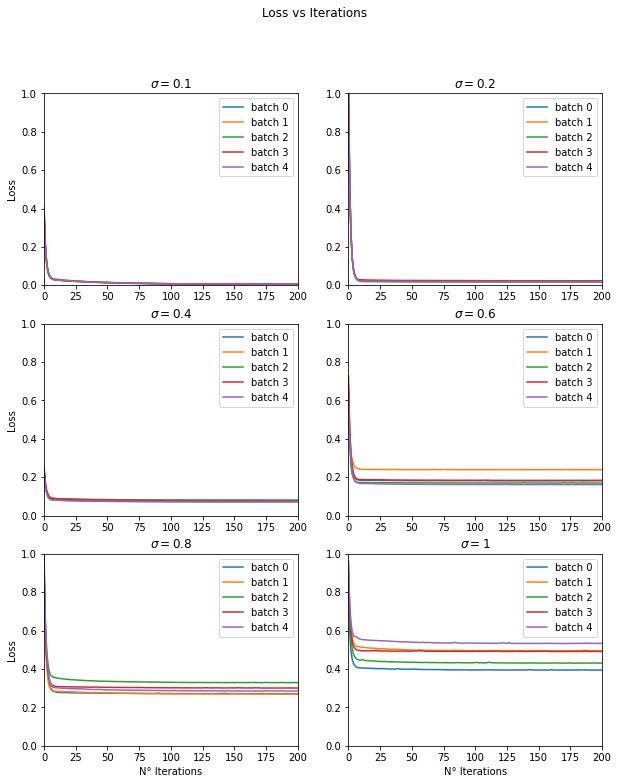

In [28]:
plot_errors(errors, sigmas)

De nuevo se puede observar que el comportamiento de la función de costo es peor a medida que los valores de la desviación estándar aumenta. Esto quiere decir que debemos cuidarnos de los datos propensos a un nivel alto de ruido porque las conclusiones que puede arrojar el modelo pueden carecer de sentido.

Para las distancias entre $\theta$ y $\xi$ obtenidas en cada una de las iteraciones, a diferencia del GD, el SGD tienen a generar resultados más homogeneos en la convergencia de las distancias a medida que los valores de $\sigma$ se incrementa. Esto nos sugiere que el SGD tiene a ser más estable para niveles más altos de desviación estándar. 

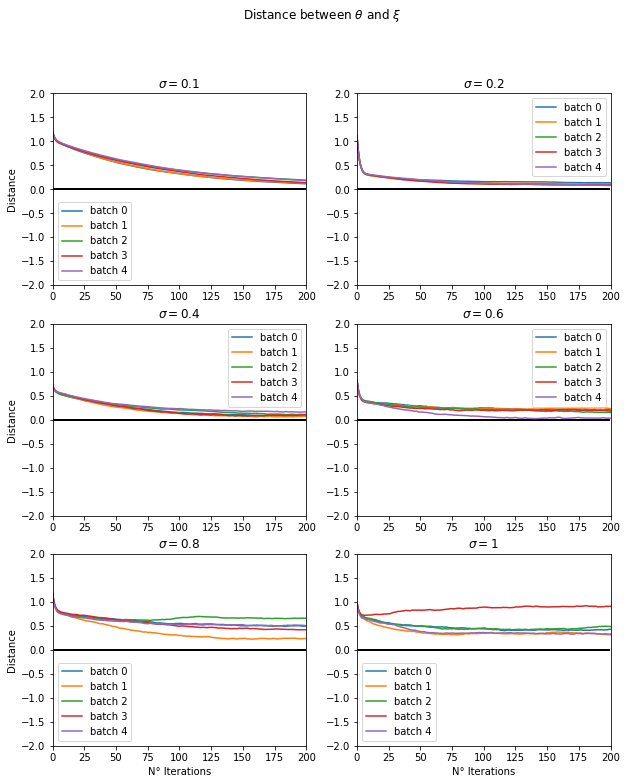

In [29]:
plot_deltas(deltas_theta, sigmas)

Recuerden que $\theta$ tiene con cuatro parámetros y para cada uno se tiene los siguientes resultados:

#### Resultados de los parámetros para la iteración 0:

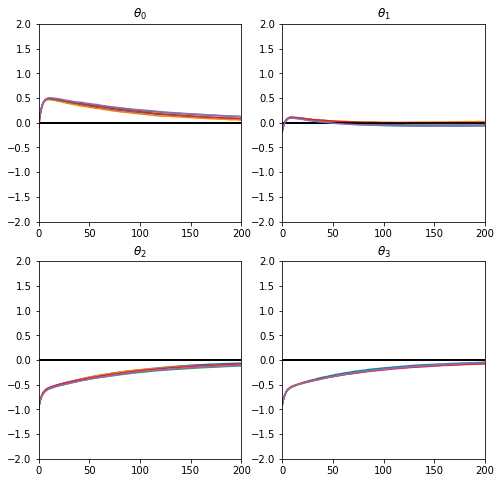

In [30]:
plot_deltas_parameters(deltas[0])

#### Resultados de los parámetros para la iteración 1:

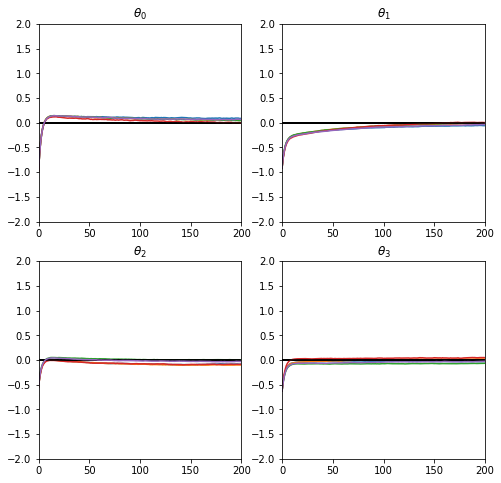

In [31]:
plot_deltas_parameters(deltas[1])

#### Resultados de los parámetros para la iteración 2:

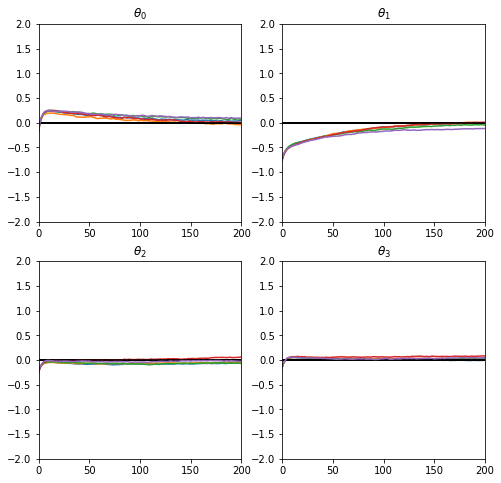

In [32]:
plot_deltas_parameters(deltas[2])

#### Resultados de los parámetros para la iteración 3:

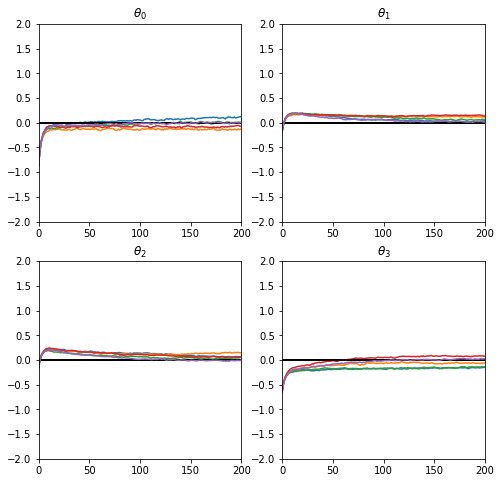

In [33]:
plot_deltas_parameters(deltas[3])

#### Resultados de los parámetros para la iteración 4:

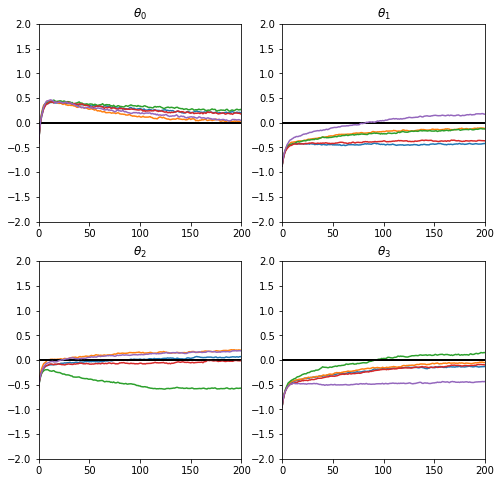

In [34]:
plot_deltas_parameters(deltas[4])

Finalmente el RMSE y el tiempos de ejecución son:

In [35]:
results(rmses, times)

,RMSE $\theta_0$,RMSE $\theta_1$,RMSE $\theta_2$,RMSE $\theta_3$,times (seg)
$\sigma=0.1$,0.096737,0.045149,0.093447,0.064667,2.204
$\sigma=0.2$,0.059325,0.031232,0.072189,0.041629,2.363
$\sigma=0.4$,0.060589,0.055827,0.052373,0.045992,2.985
$\sigma=0.6$,0.083207,0.086931,0.072005,0.100529,2.360
$\sigma=0.8$,0.165250,0.272676,0.290091,0.218889,2.852
$\sigma=1.0$,0.260187,0.360687,0.223645,0.206132,2.861


Hay que señalar que cuando la función de costo es muy irregular, esto puede ayudarr al algoritmo a evitar los mínimos locales, por lo que SGD tiene más posibilidades de encontrar el mínimo gobla que GD.

Por lo tanto, la aleatoriedad es buena  para escapar de los óptimos locales, pero mala porque significa que el algoritmo nunca puede establecerse en el mínimo. Una solución a este dilema es reducir gradualmente la tasa de aprendizaje. Los pasos comienzan siendo grandes (lo que ayuda a avanzar rápidamente y escapar de los mínimos locales), luego se vuelven cada vez más pequeños, lo que permite que el algoritmo se establezca en el mínimo global.

La función que determina la tasa de aprendizaje en cada iteración se llama programa de aprendizaje, esto se estudiará en otra ocasión. Si la tasa de aprendizaje se reduce demasiado rápido, puede quedarse atascado en un mínimo local, o incluso terminar congelado a la mitad del camino hacía el mínimo global. Si la tasa de aprendizaje se reduce demasiado lentamente, puede saltar alrededor del mínimo durante mucho tiempo y terminar con una solución subóptima si se detiene el entrenamiento demasiado pronto.

## Gradiente descendente estocástico por minilotes (Mini-Batch SGD)

El último algoritmo de gradiente descendente que veremos se llama el gradiente descente estocástico por mini lotes. Es fácil de entender una vez que se conoce el gradiente descendente clásico y el estocástico: en cada paso, en lugar de calcular los gradientes en función del conjunto de entrenamiento completo (como en GD) o en un ejemplo como en SGD, el Mini-Batch SGD calcula el  gradiente en pequeñas partes de los datos, llamadas mini lotes. La principal ventaja de Mini-batch SGD sobre SGD y GD es que puede obtener un aumento del rendimiento  mediante la optimización del hardware de las operaciones matriciales, especialmente cuando se utilizan GPU.

Una parte de los datos se denomina minilote (Mini-batch), mientras que todo el conjunto de entrenamiento $S$ se denomina lote. Estos minilotes se generan seleccionando aleatoriamente los vectores fila de la matriz $X$. El esquema general de este algoritmo sería:

#### *Algoritmo 3. Gradiente Descendente Estocástico por minilotes*
<blockquote>    
Input: $\theta$, $X$, $Y$, $t$, $ \alpha$, $\nabla E_{S}$, $size\_batch$
<br>1. &nbsp;&nbsp;&nbsp;for $k=1$ to $t$ do:
<br>2. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $l=1$ to $m$ do:
<br>3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$[i_{0, k}, \dots, i_{size\_batch, k}] = choose\_indexes(X)$
<br>4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$\theta\leftarrow \theta - \alpha \nabla E_{S}(\theta, X[i_{0, k}, \dots, i_{size\_batch, k}], Y[i_{0, k}, \dots, i_{size\_batch, k}])$
<br>5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;end    
<br>return: $\theta$
</blockquote>

Intuitivamente el algoritmo converge si SGD converge. Un implementación rápida de este algoritmo sería:

In [36]:
def sdg_mini_batch(predictor, X, Y, t, alpha, gradient, size_batch):
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        size_batch: it's a integer number no negative.
        
    Output:
        The best predictor.
    """
    theta = predictor.theta
    epochs = 0
    indexes = np.arange(X.shape[0]).tolist()
    m = len(X)
        
    while epochs <= t:
        
        for _ in range(m):
            indexes_batch = np.random.choice(indexes, size_batch)
            sgrad = gradient(theta, X[indexes_batch], Y[indexes_batch])
            theta = theta - alpha * sgrad

        epochss += 1
        
    predictor.theta = theta
    return predictor

Para nuestros objetivos también se hizo algunas modificaciones para que nos permiten analizar su comportamiento:

In [37]:
def sdg_mini_batch(predictor, X, Y, t, alpha, gradient, size_batch, loss=None, xi=None):
    """
    Input:
        predictor: it's a predictor function.
        X: it's a matrix with the independent data.
        Y: it's a matrix with the dependent data.
        t: it's the maximum number of iterations. 
        alpha: it's the learning rate.
        gradient: it's a gradient function of the predictor function.
        size_batch: it's a integer number no negative.
        loss: it's the loss function.
        xi: it's ana array with real parameters.
    Output:
        The best predictor.
    """
    theta = predictor.theta
    epochs = 0
    indexes = np.arange(X.shape[0]).tolist()
    m = len(X)
    
    delta_theta = list()
    deltas_thetas = theta.reshape(-1, 1) - xi.reshape(-1, 1)
    errors = list()
    sample = tuple([X, Y])  
        
    while epochs < t:
        
        for _ in range(m):
            indexes_batch = np.random.choice(indexes, size_batch)
            sgrad = gradient(theta, X[indexes_batch], Y[indexes_batch])
            theta = theta - alpha * sgrad 
            predictor.theta = theta
          
        errors.append(loss(predictor=predictor, sample=sample))
        delta_theta.append(euclidean_distance(theta, xi))
        arg = theta-xi
        deltas_thetas = np.hstack((deltas_thetas, arg))
        
        epochs += 1
        
        
    return predictor, errors, delta_theta, deltas_thetas

### Simulaciones de Mini-Batch SGD en ambientes controlados

A continuación se va a ejecutar variables simulaciones con desviación estándar $\sigma = 0.1, 0.2, 0.4, 0.4, 0.6, 0.8$ con $m=3$ y  seis lotes de 200 datos. Además vamos a considerar todas las simulaciones con un número máximo de 200 iteraciones y una tasa de aprendizaje de 0.001. El lector puede variar estos parámetros para hacer sus propios análisis. La configuración sería:

In [38]:
parameters = dict(t=200, alpha=0.001, gradient=gradient, size_batch=5, loss=loss)
sigmas = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
m, k, r = 3, 200, 5

Ejecutamos las simulaciones:

In [39]:
answers = execute(m=m, k=k, r=r, sigmas=sigmas, gradient_method=sdg_mini_batch, parameters_grad=parameters)
errors, deltas, deltas_theta, rmses, times = answers

Y visualizamos cada unos de los resultados. A continuación vemos el comportamiento de la función de costo para uno de los valores de sigma:

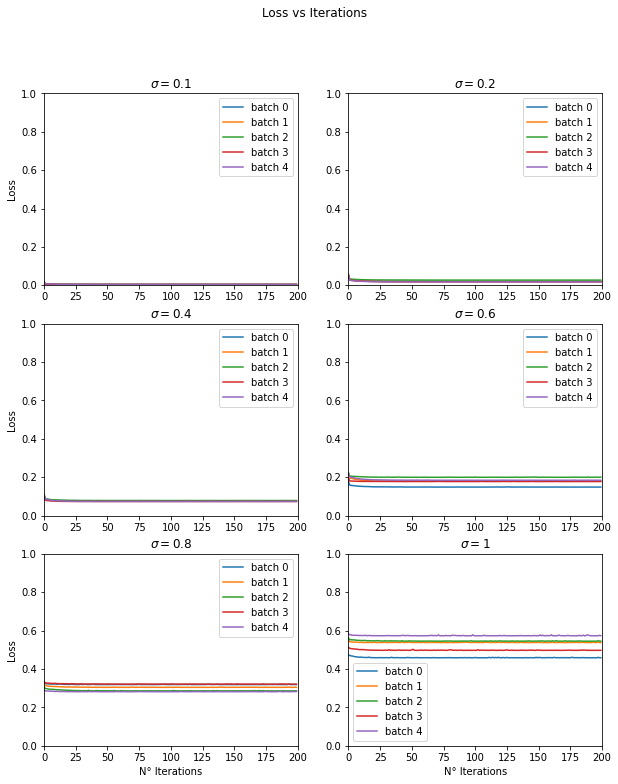

In [40]:
plot_errors(errors, sigmas)

De nuevo se puede observar que el comportamiento de la función de costo es peor a medida que los valores de la desviación estándar aumenta. Esto quiere decir que debemos cuidarnos de los datos propensos a un nivel alto de ruido porque las conclusiones que  puede arrojar el modelo pueden carecer de sentido.

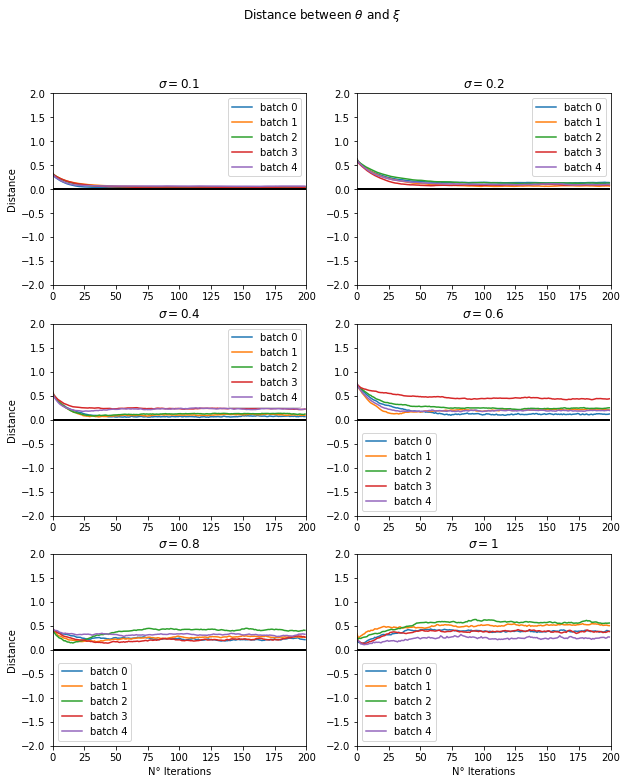

In [41]:
plot_deltas(deltas_theta, sigmas)

A continuación se puede notar que este algoritmo en el espacio de parámetros es menos errático que con SGD, especialmente con mini-lotes bastante grandes. Como resultado, el Mini-Batch SGD terminará caminando un poco más cerca del mínimo que el SGD, pero puede ser más difícil para él escapar de los mínimos locales.

#### Resultados de los parámetros para la iteración 0:

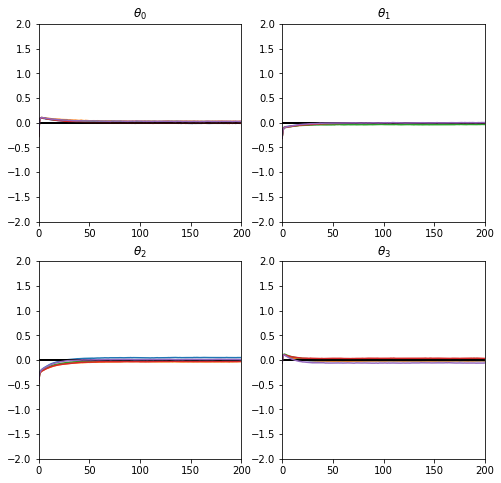

In [42]:
plot_deltas_parameters(deltas[0])

#### Resultados de los parámetros para la iteración 1:

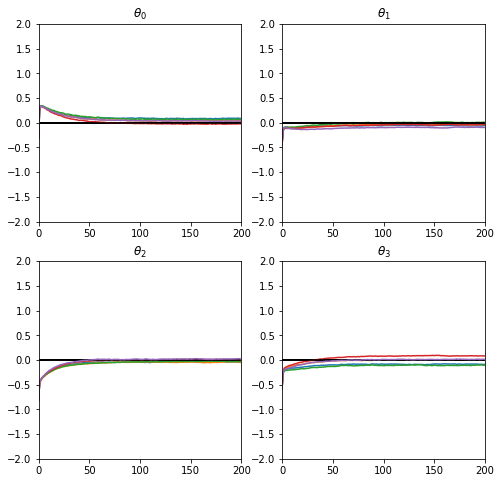

In [43]:
plot_deltas_parameters(deltas[1])

#### Resultados de los parámetros para la iteración 2:

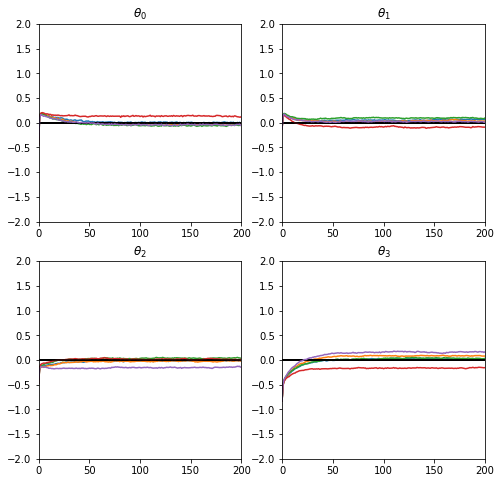

In [44]:
plot_deltas_parameters(deltas[2])

#### Resultados de los parámetros para la iteración 3:

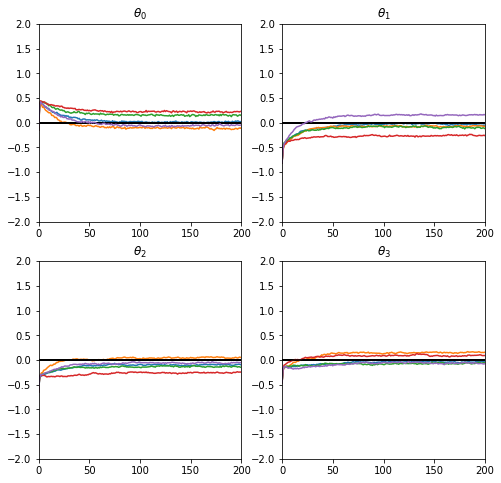

In [45]:
plot_deltas_parameters(deltas[3])

#### Resultados de los parámetros para la iteración 4:

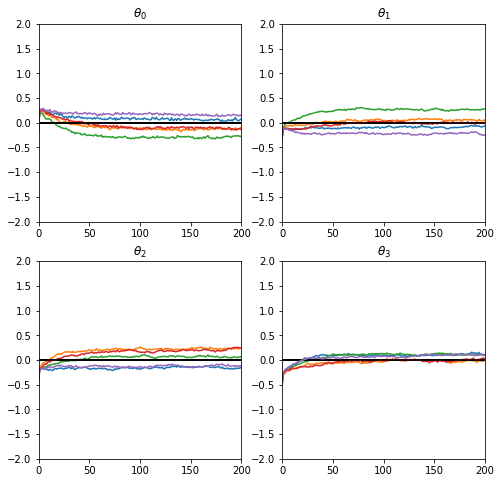

In [46]:
plot_deltas_parameters(deltas[4])

In [47]:
results(rmses, times)

,RMSE $\theta_0$,RMSE $\theta_1$,RMSE $\theta_2$,RMSE $\theta_3$,times (seg)
$\sigma=0.1$,0.020485,0.017548,0.031923,0.033223,2.837
$\sigma=0.2$,0.055847,0.055789,0.031316,0.071602,2.497
$\sigma=0.4$,0.063609,0.066269,0.067951,0.108116,2.602
$\sigma=0.6$,0.129320,0.151790,0.142006,0.091833,2.787
$\sigma=0.8$,0.155734,0.173697,0.175209,0.077381,2.525
$\sigma=1.0$,0.142106,0.271400,0.164148,0.258114,2.434


En cuanto al RMSE, parece existir una ligera mejora a medida que se incrementa el ruido, sin embargo no podemos sacar conclusiones aún. Te invito a hacer varias simulaciones con diferentes parámetros y nos compartas tus resultados. Nos vemos en otra ocasión.

No olvides comentar y suscribirte al blog para que estés enterando de los posts que voy a ir subiendo semana a semana. También sientete en libertad de seguirme en LinkedIn, Twitter, Github e Instagram. 

## Bibliografía
1. Sebastián Ruder. 2017. An overview of gradient descent optimization algorithms. Insight Centre for Data Analytics, Nui Galway.
2. Mustafa Murat. 2019. [Logistic Regression in TensorFlow](https://mmuratarat.github.io/2019-01-07/logistic-regression-in-Tensorflow).
3. Aurelien Geron. 2019. Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow.

## Notas
<a id="1">[1]</a>. Si $y_{\min}$ es el mínimo global de una función $f(x)$, entonces se define el operador $\operatorname*{argmin\,\,}$ como siguiente conjunto: $$\operatorname*{argmin\,\,}_{ x \in X} f(x) = \{x\in X: f(x) = y_\min\}.$$
<a id="2">[2]</a>. El conjunto $[r]_{\mathbb{N}_0}$ es $\{0, 1, 2,\dots, r\}$.

## Contacto
* Participa de la canal de Nerve a través de [Discord](https://discord.gg/edPmghPq8K).
* Se quieres conocer más acerca de este tema me puedes contactar a través de [Classgap](https://www.classgap.com/me/alejandro-sanchez-yali).